In [1]:
import requests
import json 
from dotenv import dotenv_values

import pandas as pd

In [2]:
#Read private API key 
#Note: will need to deal with this with Heroku's config vars for deployment
config = dotenv_values('.env')
etsy_key = config['x-api-key']


In [3]:
headers = { 'x-api-key' : etsy_key }

# Part I: Download basic listing data (price, dimensions, materials, etc.) for all paintings for sale within a certain price range. 

## Preparatory Steps

### Get the full hierarchy tree of seller taxonomy nodes, to find the one I am interested in (paintings)

In [4]:
url_taxonomy = 'https://openapi.etsy.com/v3/application/seller-taxonomy/nodes'

In [5]:
response_taxonomy = requests.get(url_taxonomy, headers = headers)

In [6]:
response_taxonomy

<Response [200]>

In [7]:
response_taxonomy_data = response_taxonomy.json() 

In [8]:
response_taxonomy_data.keys()

dict_keys(['count', 'results'])

In [9]:
#results is a list of nested dictionaries
len(response_taxonomy_data['results'])

15

In [10]:
#lets's start with the main tree to see the 15 main categories and find where painting may be
[(main_category['name'], counter) for counter, main_category in enumerate(response_taxonomy_data['results'])]

[('Accessories', 0),
 ('Art & Collectibles', 1),
 ('Bags & Purses', 2),
 ('Bath & Beauty', 3),
 ('Books, Movies & Music', 4),
 ('Clothing', 5),
 ('Craft Supplies & Tools', 6),
 ('Electronics & Accessories', 7),
 ('Home & Living', 8),
 ('Jewelry', 9),
 ('Paper & Party Supplies', 10),
 ('Pet Supplies', 11),
 ('Shoes', 12),
 ('Toys & Games', 13),
 ('Weddings', 14)]

In [11]:
#Let's dive into Art and Collectibles
[(art_category['name'], counter) for counter, art_category in enumerate(response_taxonomy_data['results'][1]['children'])]
#response_taxonomy_data['results'][1]['children']

[('Collectibles', 0),
 ('Drawing & Illustration', 1),
 ('Fiber Arts', 2),
 ('Mixed Media & Collage', 3),
 ('Glass Art', 4),
 ('Painting', 5),
 ('Photography', 6),
 ('Prints', 7),
 ('Sculpture', 8),
 ('Dolls & Miniatures', 9),
 ('Artist Trading Cards', 10),
 ('Fine Art Ceramics', 11)]

In [12]:
#Let's look at painting
response_taxonomy_data['results'][1]['children'][5]

{'id': 105,
 'level': 2,
 'name': 'Painting',
 'parent_id': 66,
 'children': [{'id': 106,
   'level': 3,
   'name': 'Acrylic',
   'parent_id': 105,
   'children': [],
   'full_path_taxonomy_ids': [66, 105, 106]},
  {'id': 107,
   'level': 3,
   'name': 'Combination',
   'parent_id': 105,
   'children': [],
   'full_path_taxonomy_ids': [66, 105, 107]},
  {'id': 108,
   'level': 3,
   'name': 'Encaustics',
   'parent_id': 105,
   'children': [],
   'full_path_taxonomy_ids': [66, 105, 108]},
  {'id': 109,
   'level': 3,
   'name': 'Gouache',
   'parent_id': 105,
   'children': [],
   'full_path_taxonomy_ids': [66, 105, 109]},
  {'id': 110,
   'level': 3,
   'name': 'Ink',
   'parent_id': 105,
   'children': [],
   'full_path_taxonomy_ids': [66, 105, 110]},
  {'id': 111,
   'level': 3,
   'name': 'Mixed',
   'parent_id': 105,
   'children': [],
   'full_path_taxonomy_ids': [66, 105, 111]},
  {'id': 112,
   'level': 3,
   'name': 'Oil',
   'parent_id': 105,
   'children': [],
   'full_path_

In [13]:
#Paintings are themselves divided into different groups based on materials, and there are no more children, so I can now collect the taxonomy id's and the full path taxonomy id's just in case
paintings_taxonomy_list = [(painting_category['name'], painting_category['id'], painting_category['full_path_taxonomy_ids']) for painting_category in response_taxonomy_data['results'][1]['children'][5]['children']]
paintings_taxonomy_list

[('Acrylic', 106, [66, 105, 106]),
 ('Combination', 107, [66, 105, 107]),
 ('Encaustics', 108, [66, 105, 108]),
 ('Gouache', 109, [66, 105, 109]),
 ('Ink', 110, [66, 105, 110]),
 ('Mixed', 111, [66, 105, 111]),
 ('Oil', 112, [66, 105, 112]),
 ('Spray Paint', 113, [66, 105, 113]),
 ('Watercolor', 114, [66, 105, 114])]

### Paintings taxonomy

In [14]:
paintings_taxonomy_df = pd.DataFrame(paintings_taxonomy_list, columns = ['Material','Taxonomy Id','Full path Id'])

In [15]:
paintings_taxonomy_df

,Material,Taxonomy Id,Full path Id
0,Acrylic,106,"[66, 105, 106]"
1,Combination,107,"[66, 105, 107]"
2,Encaustics,108,"[66, 105, 108]"
3,Gouache,109,"[66, 105, 109]"
4,Ink,110,"[66, 105, 110]"
5,Mixed,111,"[66, 105, 111]"
6,Oil,112,"[66, 105, 112]"
7,Spray Paint,113,"[66, 105, 113]"
8,Watercolor,114,"[66, 105, 114]"


In [143]:
#I am also adding the number of available paintings in the price range of my interest ($250-$500), which I manually checked (as of 10/5):
#paintings_taxonomy_df['num_listings_250to500USD']=[75333, 4084, 579, 1088, 1137, 6312, 77630, 354, 16597]
paintings_taxonomy_df['num_listings_250to750USD']=[92172, 5068, 721, 1299, 1371, 8026, 97396, 422, 19796]

In [142]:
paintings_taxonomy_df

,Material,Taxonomy Id,Full path Id,num_listings_250to750USD
0,Acrylic,106,"[66, 105, 106]",92172
1,Combination,107,"[66, 105, 107]",5068
2,Encaustics,108,"[66, 105, 108]",721
3,Gouache,109,"[66, 105, 109]",1299
4,Ink,110,"[66, 105, 110]",1371
5,Mixed,111,"[66, 105, 111]",8026
6,Oil,112,"[66, 105, 112]",97596
7,Spray Paint,113,"[66, 105, 113]",422
8,Watercolor,114,"[66, 105, 114]",19796


In [18]:
paintings_taxonomy_df['num_listings_250to750USD'].sum()

229471

In [19]:
paintings_taxonomy_df.set_index('Taxonomy Id')


,Material,Full path Id,num_listings_250to750USD
Taxonomy Id,,,
106,Acrylic,"[66, 105, 106]",95172
107,Combination,"[66, 105, 107]",5068
108,Encaustics,"[66, 105, 108]",721
109,Gouache,"[66, 105, 109]",1299
110,Ink,"[66, 105, 110]",1371
111,Mixed,"[66, 105, 111]",8026
112,Oil,"[66, 105, 112]",97596
113,Spray Paint,"[66, 105, 113]",422
114,Watercolor,"[66, 105, 114]",19796


In [20]:
paintings_taxonomy_df.set_index('Taxonomy Id').loc[106]

Material                           Acrylic
Full path Id                [66, 105, 106]
num_listings_250to750USD             95172
Name: 106, dtype: object

In [21]:
#Now let's request the properties given for each listing in these categories, with a separate request
url_properties_acrylic = 'https://openapi.etsy.com/v3/application/seller-taxonomy/nodes/106/properties'
response_properties_acrylic = requests.get(url_properties_acrylic, headers = headers)
response_properties_acrylic_data = response_properties_acrylic.json() 

In [22]:
response_properties_acrylic_data.keys()

dict_keys(['count', 'results'])

In [23]:
paintings_property_list_acrylic = [(painting_property['property_id'], painting_property['name']) for painting_property in response_properties_acrylic_data['results']]
paintings_property_list_acrylic

[(200, 'Primary color'),
 (52047899002, 'Secondary color'),
 (400394338806, 'Art subject'),
 (570246213481, 'Art style'),
 (145330288652, 'Home style'),
 (570246213482, 'Surface material'),
 (406291158455, 'Orientation'),
 (145330288558, 'Framing'),
 (47626759834, 'Height'),
 (47626759898, 'Width'),
 (54142602037, 'Depth'),
 (145330288592, 'Room'),
 (46803063659, 'Holiday'),
 (46803063641, 'Occasion'),
 (504, 'Diameter'),
 (501, 'Dimensions'),
 (502, 'Fabric'),
 (500, 'Finish'),
 (503, 'Flavor'),
 (506, 'Length'),
 (507, 'Material'),
 (508, 'Pattern'),
 (509, 'Scent'),
 (100, 'TeeShirtSize'),
 (510, 'Style'),
 (511, 'Weight'),
 (515, 'Device'),
 (513, 'Custom1'),
 (514, 'Custom2')]

In [24]:
#Let's check that the same properties and code apply to the other paintings' types, e.g. spray paint:

url_properties_spraypaint = 'https://openapi.etsy.com/v3/application/seller-taxonomy/nodes/113/properties'
response_properties_spraypaint = requests.get(url_properties_spraypaint, headers = headers)
response_properties_spraypaint_data = response_properties_spraypaint.json() 


In [25]:
paintings_property_list_spraypaint = [(painting_property['property_id'], painting_property['name']) for painting_property in response_properties_spraypaint_data['results']]
paintings_property_list_spraypaint

[(200, 'Primary color'),
 (52047899002, 'Secondary color'),
 (400394338806, 'Art subject'),
 (570246213481, 'Art style'),
 (145330288652, 'Home style'),
 (570246213482, 'Surface material'),
 (406291158455, 'Orientation'),
 (145330288558, 'Framing'),
 (47626759834, 'Height'),
 (47626759898, 'Width'),
 (54142602037, 'Depth'),
 (145330288592, 'Room'),
 (46803063659, 'Holiday'),
 (46803063641, 'Occasion'),
 (504, 'Diameter'),
 (501, 'Dimensions'),
 (502, 'Fabric'),
 (500, 'Finish'),
 (503, 'Flavor'),
 (506, 'Length'),
 (507, 'Material'),
 (508, 'Pattern'),
 (509, 'Scent'),
 (100, 'TeeShirtSize'),
 (510, 'Style'),
 (511, 'Weight'),
 (515, 'Device'),
 (513, 'Custom1'),
 (514, 'Custom2')]

In [26]:
#So this confirms that the possible properties for a painting don't change by material 

In [27]:
paintings_properties_df = pd.DataFrame(paintings_property_list_spraypaint, columns = ['Property Id','Property'])

In [28]:
paintings_properties_df

,Property Id,Property
0,200,Primary color
1,52047899002,Secondary color
2,400394338806,Art subject
3,570246213481,Art style
4,145330288652,Home style
5,570246213482,Surface material
6,406291158455,Orientation
7,145330288558,Framing
8,47626759834,Height
9,47626759898,Width


### Test GET request of the 'find all listings' type

limit = num. listings to return (1-100, default 25)

offset = for skipping responses (default 0)

#keywords = search term or phrase that must appear (e.g. tree)

sort_on = can be ('created', 'price', 'updated', default 'created')

sort_order = 'ascending' or 'descending'

min_price, max_price 

taxonomy_id = code for the type of painting: (106-114, 106 = acrylic, ...., 114=watercolor)

In [29]:
params = { 'limit' :100, #listings to return (1-100, default 25)
            'offset' : 0,  #for skipping responses (default 0)
            'sort_on': 'price',  #can be ('created', 'price', 'updated', default 'created')
            'sort_order' : 'ascending', #'descending'
             'min_price' : 250.0,
             'max_price' : 750.0,
             'taxonomy_id' : 106 #106 = acrylic, ...., 114=watercolor 
         }

In [30]:
url_listings_active = 'https://openapi.etsy.com/v3/application/listings/active'

In [31]:
response_paintings_active = requests.get(url_listings_active, params=params, headers = headers)

In [32]:
response_paintings_active

<Response [200]>

In [33]:
response_paintings_active_data = response_paintings_active.json() 

In [34]:
response_paintings_active_data.keys()

dict_keys(['count', 'results'])

In [35]:
response_paintings_active_data['results'][0:2]

[{'listing_id': 709728321,
  'user_id': 51263324,
  'shop_id': 9800755,
  'title': 'Original Orchid Flower Painting, Flower Painting Still Life, Small Original Painting',
  'description': 'Acrylic on Hardboard',
  'state': 'active',
  'creation_timestamp': 1631647252,
  'ending_timestamp': 1642191652,
  'original_creation_timestamp': 1559054965,
  'last_modified_timestamp': 1631647252,
  'state_timestamp': 1569768624,
  'quantity': 1,
  'shop_section_id': 26402930,
  'featured_rank': -1,
  'url': 'https://www.etsy.com/listing/709728321/original-orchid-flower-painting-flower',
  'num_favorers': 29,
  'non_taxable': False,
  'is_customizable': False,
  'is_personalizable': False,
  'personalization_is_required': False,
  'personalization_char_count_max': None,
  'personalization_instructions': None,
  'listing_type': 0,
  'tags': ['Floral Painting',
   'Still Life Painting',
   'Orchid Painting',
   'Flower Painting',
   'Acrylic Painting',
   'Anniversary Gift',
   'Birthday Gift',
   '

In [36]:
first_100acrylic_paintings_df =  pd.DataFrame(response_paintings_active_data['results'],columns=['listing_id','user_id','shop_id','title','num_favorers','url','materials','item_length','item_width','item_dimensions_unit','style','price','taxonomy_id'])

In [37]:
first_100acrylic_paintings_df

,listing_id,user_id,shop_id,title,num_favorers,url,materials,item_length,item_width,item_dimensions_unit,style,price,taxonomy_id
0,709728321,51263324,9800755,"Original Orchid Flower Painting, Flower Painti...",29,https://www.etsy.com/listing/709728321/origina...,"[Acrylic, Hardboard]",24,18,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
1,819018692,221539362,20402975,"Long wall art, Oversized wall art, Large Abstr...",2,https://www.etsy.com/listing/819018692/long-wa...,"[acrylic, pastels, paper roll]",None,None,None,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
2,1076101360,74239808,25674777,Deep Blue Sea,0,https://www.etsy.com/listing/1076101360/deep-b...,[],20,1,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
3,1001369872,440513424,27718104,Colosal ocean wave,0,https://www.etsy.com/listing/1001369872/colosa...,[Stretched canvas],23.5,1.5,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
4,968717160,21677727,6902246,Freedom 8x10 framed,0,https://www.etsy.com/listing/968717160/freedom...,[],10,8,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,895747673,230092638,20768657,Peacock,0,https://www.etsy.com/listing/895747673/peacock,[Stretched canvas],16,12,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
96,828089877,13023446,12985729,Peonies for my father,1,https://www.etsy.com/listing/828089877/peonies...,[Stretched canvas],35,28,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
97,771054512,273090558,22377768,Guacamole Architecture. Abstract art and divin...,0,https://www.etsy.com/listing/771054512/guacamo...,"[acrylic, metallic]",25,17,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106
98,583235330,64566326,11093744,Pure - Original Artwork,0,https://www.etsy.com/listing/583235330/pure-or...,"[glass, acrylic, paint, gold, blue, red, white...",42,11,in,[],"{'amount': 25000, 'divisor': 100, 'currency_co...",106


In [38]:
first_100acrylic_paintings_df =  pd.DataFrame(response_paintings_active_data['results'])
first_100acrylic_paintings_df

,listing_id,user_id,shop_id,title,description,state,creation_timestamp,ending_timestamp,original_creation_timestamp,last_modified_timestamp,...,item_dimensions_unit,is_private,style,file_data,has_variations,should_auto_renew,language,price,taxonomy_id,production_partners
0,709728321,51263324,9800755,"Original Orchid Flower Painting, Flower Painti...",Acrylic on Hardboard,active,1631647252,1642191652,1559054965,1631647252,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
1,819018692,221539362,20402975,"Long wall art, Oversized wall art, Large Abstr...","Long wall art, Oversized wall art, Large Abstr...",active,1629146443,1639690843,1593681450,1633613182,...,None,False,[],,True,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
2,1076101360,74239808,25674777,Deep Blue Sea,Bucket of blues in this acrylic painting on a ...,active,1632432869,1642977269,1632432869,1632632468,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
3,1001369872,440513424,27718104,Colosal ocean wave,Abstract modern acrylic painting,active,1631137250,1641681650,1620423588,1631137250,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
4,968717160,21677727,6902246,Freedom 8x10 framed,Freedom \n8x10 in a high quality frame \nAll p...,active,1626605436,1637236236,1615978050,1626605436,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,895747673,230092638,20768657,Peacock,Blue Peacock \nPainting on stretched canvas\n\...,active,1604083431,1614541431,1604082908,1616747092,...,in,False,[],,False,False,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
96,828089877,13023446,12985729,Peonies for my father,Acrylic painting of peonies in a vase\n- paint...,active,1624637433,1635178233,1592841613,1624637433,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
97,771054512,273090558,22377768,Guacamole Architecture. Abstract art and divin...,Guacamole Architecture is part of a larger ser...,active,1626035433,1636666233,1583614746,1626035433,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
98,583235330,64566326,11093744,Pure - Original Artwork,This original piece is sure to make a statemen...,active,1625725230,1636356030,1519801011,1625725230,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]


In [39]:
#Other available requests are: 'FindAllActiveListingsbyShop', 'getListing' (to get a single listing), 'getListingsByListingIds' (pass a list of ids),  'getListingProperties' (to return a single property by id)
#'getAllListingFiles' that returns all the files associated to a listing (including images?) - this requires OAuth2 

In [40]:
#Test of concatenation
first50acrylic_paintings_df = first_100acrylic_paintings_df.iloc[:50]

In [41]:
second50acrylic_paintings_df = first_100acrylic_paintings_df.iloc[50:]

In [42]:
first50acrylic_paintings_df = pd.concat([first50acrylic_paintings_df,second50acrylic_paintings_df])

In [43]:
first50acrylic_paintings_df

,listing_id,user_id,shop_id,title,description,state,creation_timestamp,ending_timestamp,original_creation_timestamp,last_modified_timestamp,...,item_dimensions_unit,is_private,style,file_data,has_variations,should_auto_renew,language,price,taxonomy_id,production_partners
0,709728321,51263324,9800755,"Original Orchid Flower Painting, Flower Painti...",Acrylic on Hardboard,active,1631647252,1642191652,1559054965,1631647252,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
1,819018692,221539362,20402975,"Long wall art, Oversized wall art, Large Abstr...","Long wall art, Oversized wall art, Large Abstr...",active,1629146443,1639690843,1593681450,1633613182,...,None,False,[],,True,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
2,1076101360,74239808,25674777,Deep Blue Sea,Bucket of blues in this acrylic painting on a ...,active,1632432869,1642977269,1632432869,1632632468,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
3,1001369872,440513424,27718104,Colosal ocean wave,Abstract modern acrylic painting,active,1631137250,1641681650,1620423588,1631137250,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
4,968717160,21677727,6902246,Freedom 8x10 framed,Freedom \n8x10 in a high quality frame \nAll p...,active,1626605436,1637236236,1615978050,1626605436,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,895747673,230092638,20768657,Peacock,Blue Peacock \nPainting on stretched canvas\n\...,active,1604083431,1614541431,1604082908,1616747092,...,in,False,[],,False,False,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
96,828089877,13023446,12985729,Peonies for my father,Acrylic painting of peonies in a vase\n- paint...,active,1624637433,1635178233,1592841613,1624637433,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
97,771054512,273090558,22377768,Guacamole Architecture. Abstract art and divin...,Guacamole Architecture is part of a larger ser...,active,1626035433,1636666233,1583614746,1626035433,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]
98,583235330,64566326,11093744,Pure - Original Artwork,This original piece is sure to make a statemen...,active,1625725230,1636356030,1519801011,1625725230,...,in,False,[],,False,True,en-US,"{'amount': 25000, 'divisor': 100, 'currency_co...",106,[]


In [44]:
test = first50acrylic_paintings_df.iloc[98]['price']
test['amount']/test['divisor']

250.0

## Here is the actual loop requesting, organizing and saving all paintings listings of a particular material (from code 106=acrylic to code 114=watercolor) within the $250-750 price range  

In [46]:
from ediblepickle import checkpoint
import os
from urllib.parse import quote

cache_dir = './Git_exclude/cache'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

In [47]:
import time

In [48]:
from retrying import retry

In [49]:
url_listings_active = 'https://openapi.etsy.com/v3/application/listings/active'

In [144]:
#This is the main workhorse function  to get 100 listings at a time, transform to dataframe and 
#the first decorator saves the results of any call with given parameters to cache, the second one keeps retrying if attampts fail
@retry(stop_max_attempt_number=100,wait_fixed=1000)
@checkpoint(key=lambda args, kwargs: 'tax'+ str(args[0]) + '_off'+ str(args[1]) + '_from' +str(int(min_price)) +'.pkl', work_dir=cache_dir)
def get_100painting_listings(taxonomy_id,offset,min_price,max_price):
    #basic parameters for the getAllListings call
    params = {'limit' :100, #listings to return (1-100, default 25)
            'offset' : offset,  #for skipping responses (default 0, it seems to work only up to 12000)
            'sort_on': 'price',  #can be ('created', 'price', 'updated', default 'created')
            'sort_order' : 'ascending', #'descending'
             'min_price' : min_price,
             'max_price' : max_price,
             'taxonomy_id' : taxonomy_id #106 = acrylic, 107 = combination,  ...., 114=watercolor 
              }
    response_100paintings = requests.get(url_listings_active, params=params, headers = headers)
    response_100paintings_data = response_100paintings.json() 
    response_100paintings_df =  pd.DataFrame(response_100paintings_data['results'])
    return response_100paintings_df

In [118]:
#I want a function to format the prices, that are returned by Etsy as a weird string like:
#"{'amount': 25000, 'divisor': 100, 'currency_code': 'USD'}"
#I want to convert the price into a floating value (amount/divisor) and throw away price that are not in USDollars as that would throw off my algorithm
import numpy as np
def format_price_USD(price_field_Etsy):
    if price_field_Etsy['currency_code']=='USD':
        return price_field_Etsy['amount']/price_field_Etsy['divisor']
    else:
        return np.nan

In [51]:
#Testing the basic iteration on taxonomy_id = 107 (combination) since there shouldn't be too many of these listings

# taxonomy_id = 107

# min_price = 250.0
# max_price = 750.0

# tax107_filename = './Git_exclude/Data/tax107_all_paintings_from_USD250.csv'

# #If the files with the listing data already exists for this taxonomy id, I load it:
# try:
#     tax107_all_paintings_df_test = pd.read_csv(tax107_filename)

#     print('Loaded listings file for taxonomy id 107.')

# except:

#     #Let's launch it a first time to initialize the dataframe with the first 100 listings of a given type
#     offset = 0
#     tax107_all_paintings_df = get_100painting_listings(taxonomy_id,offset,min_price,max_price)
    
#     #Then iterate over all paintings of that same type, which number is given in the paintings taxonomy df filled earlier
#     tax107_num_listings = paintings_taxonomy_df.set_index('Taxonomy Id').loc[107]['num_listings_250to750USD']
#     tax107_offsets_list = range(100,tax107_num_listings,100)
    
#     for offset in tax107_offsets_list:
#         tax107_100paintings_df = get_100painting_listings(107,offset,min_price,max_price)
#         tax107_all_paintings_df = pd.concat([tax107_all_paintings_df, tax107_100paintings_df])
#         time.sleep(1)
    
#     #save to .csv file
#     tax107_all_paintings_df.to_csv(tax107_filename,index=False)
        
#     print('Saved listings file for taxonomy id 107.')    

In [52]:
#Testing a more complicated iteration on taxonomy_id = 114, which has ~20000 entries, but I want to break the results into chunks of at most 12000 entries each
#because request calls with offset>=12000 fail and so need to be handled appropriately

# taxonomy_id = 114

# tax114_filename = './Git_exclude/Data/tax114_all_paintings_from_USD250.csv'

# #total number of listings:
# tax_id_num_listings = paintings_taxonomy_df.set_index('Taxonomy Id').loc[taxonomy_id]['num_listings_250to750USD']
# tax_id_num_listings

# #starting offsets for each chunk:
# starting_offsets = range(0,tax_id_num_listings,12000)

# min_price = 250.0
# max_price = 750.0

# for i,starting_offset in enumerate(starting_offsets):
    
#     if i>0:
#         tax114_next_csv_filename = tax114_filename[:-4]+f'_{i}.csv'
#     else:
#         tax114_next_csv_filename = tax114_filename
    

#     #If the files with the listing data already exists for this taxonomy id, I load it:
#     try:
#         tax_id_all_paintings_df = pd.read_csv(tax114_next_csv_filename)

#         print(f'Loaded listings file {tax114_next_csv_filename} for taxonomy id {taxonomy_id}.')

#     except:

#         #Since the GET request seem to work only for offset<=12000, i.e. only for the first iteration of this code, for the following iterations
#         #I use the following trick: after every multiple of 12000, I update the min price to look for and then use offset numbers modulo 12000
        
#         #Let's launch get_100painting_listings a first time to initialize the dataframe with the first 100 listings of a given type
#         tax_id_all_paintings_df = get_100painting_listings(taxonomy_id,starting_offset%12000,min_price,max_price)

#         #Then iterate attaching 100 painting listings at a time until reaching 12000 or the end
#         if i<(len(starting_offsets)-1):
#             tax_id_offsets_list = range(starting_offset+100,starting_offsets[i+1],100)
#         else:
#             tax_id_offsets_list = range(starting_offset+100,tax_id_num_listings,100)

#         for offset in tax_id_offsets_list:
#             tax_id_100paintings_df = get_100painting_listings(taxonomy_id,offset%12000,min_price,max_price)
#             tax_id_all_paintings_df = pd.concat([tax_id_all_paintings_df, tax_id_100paintings_df])
#             time.sleep(1)
            
#         #if I reached here and this is not the last call, update the min price to the next integer value so that the next block of 12000 offsets does not overlap with the previous
#         #set of entries:
#         if i<(len(starting_offsets)-1):
#             last_price_field = tax_id_all_paintings_df.iloc[-1]['price']
#             min_price = 0.1 + (last_price_field['amount']/last_price_field['divisor'])
            
#         #save to .csv file
#         tax_id_all_paintings_df.to_csv(tax114_next_csv_filename,index=False)
#         print(f'Saved listings file {tax114_next_csv_filename} for taxonomy id {taxonomy_id}.')

    

In [145]:
#Iterate over all taxonomies of interest

taxonomies_of_interest = [106] #[106, 107, 108, 109, 110, 111, 112, 113, 114]

for taxonomy_id in taxonomies_of_interest:

    min_price = 250.0
    max_price = 750.0
    
    csv_filename = f'./Git_exclude/Data/tax{taxonomy_id}_all_paintings_from_USD{int(min_price)}.csv'
    
    #total number of listings:
    tax_id_num_listings = paintings_taxonomy_df.set_index('Taxonomy Id').loc[taxonomy_id]['num_listings_250to750USD']

    #I want to break this into chunks of at most 12000 entries each (because requests with larger offsets fail)
    
    #starting offsets for each chunk:
    starting_offsets = range(0,tax_id_num_listings,12000)
    
    for i,starting_offset in enumerate(starting_offsets):

        if i>0:
            next_csv_filename = csv_filename[:-4]+f'_{i}.csv'
        else:
            next_csv_filename = csv_filename

        #If the files with the listing data already exists for this taxonomy id, I load it:
        try:
            tax_id_all_paintings_df = pd.read_csv(next_csv_filename)

            print(f'Loaded listings file {next_csv_filename} for taxonomy id {taxonomy_id}.')
            
            #if I reached here and this is not the last call, update the min price to the next decimal value so that the next block of 12000 offsets does not overlap with the previous
            #set of entries:
            if i<(len(starting_offsets)-1):
                last_price = tax_id_all_paintings_df.iloc[-1]['price']
                min_price = 0.1 + last_price
                print(min_price)

        except:

            #Since the GET request seem to work only for offset<=12000, i.e. only for the first iteration of this code, for the following iterations
            #I use the following trick: after every multiple of 12000, I update the min price to look for and then use offset numbers modulo 12000

            #Let's launch get_100painting_listings a first time to initialize the dataframe with the first 100 listings of a given type
            tax_id_all_paintings_df = get_100painting_listings(taxonomy_id,starting_offset%12000,min_price,max_price)

            #Then iterate attaching 100 painting listings at a time until reaching 12000 or the end
            if i<(len(starting_offsets)-1):
                tax_id_offsets_list = range(starting_offset+100,starting_offsets[i+1],100)
            else:
                tax_id_offsets_list = range(starting_offset+100,tax_id_num_listings,100)

            for offset in tax_id_offsets_list:
                tax_id_100paintings_df = get_100painting_listings(taxonomy_id,offset%12000,min_price,max_price)
                tax_id_all_paintings_df = pd.concat([tax_id_all_paintings_df, tax_id_100paintings_df])
                time.sleep(1)

            #clean the price column by making it into a float and removing if currency is not USD    
            tax_id_all_paintings_df['price']=tax_id_all_paintings_df['price'].apply(format_price_USD)
            tax_id_all_paintings_df.dropna(axis=0,subset=['price'],inplace=True)
                
            #if I reached here and this is not the last call, update the min price to the next decimal value so that the next block of 12000 offsets does not overlap with the previous
            #set of entries:
            if i<(len(starting_offsets)-1):
                last_price = tax_id_all_paintings_df.iloc[-1]['price']
                min_price = 0.1 + last_price

            #save to .csv file
            tax_id_all_paintings_df.to_csv(next_csv_filename,index=False)
            print(f'Saved listings file {next_csv_filename} for taxonomy id {taxonomy_id}.')


Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD250.csv for taxonomy id 106.
270.1
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD250_1.csv for taxonomy id 106.
300.1
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD250_2.csv for taxonomy id 106.
350.1
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD250_3.csv for taxonomy id 106.
400.1
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD250_4.csv for taxonomy id 106.
457.65000000000003
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD250_5.csv for taxonomy id 106.
529.1
Loaded listings file ./Git_exclude/Data/tax106_all_paintings_from_USD250_6.csv for taxonomy id 106.
648.1
Saved listings file ./Git_exclude/Data/tax106_all_paintings_from_USD250_7.csv for taxonomy id 106.


In [130]:
tax_id_num_listings

95172

In [131]:
list(range(0,tax_id_num_listings,12000))

[0, 12000, 24000, 36000, 48000, 60000, 72000, 84000]

In [138]:

params = {'limit' :100, #listings to return (1-100, default 25)
            'offset' : 8400,  #for skipping responses (default 0, it seems to work only up to 12000)
            'sort_on': 'price',  #can be ('created', 'price', 'updated', default 'created')
            'sort_order' : 'ascending', #'descending'
             'min_price' : 648.1,
             'max_price' : 750.0,
             'taxonomy_id' : 106 #106 = acrylic, 107 = combination,  ...., 114=watercolor 
              }

response_100paintings = requests.get(url_listings_active, params=params, headers = headers)

#test = get_100painting_listings(106,8400,648.1,750.0)

In [140]:
response_100paintings.reason

'Bad Request'

In [405]:
#check taxonomy 111:
csv_filename = f'./Git_exclude/Data/tax{111}_all_paintings.csv'

In [406]:
tax_111_all_paintings_df_test = pd.read_csv(csv_filename)

In [407]:
len(tax_111_all_paintings_df_test)

8100

In [414]:
tax_111_all_paintings_df_test['price']

0       {'amount': 25000, 'divisor': 100, 'currency_co...
1       {'amount': 25000, 'divisor': 100, 'currency_co...
2       {'amount': 25000, 'divisor': 100, 'currency_co...
3       {'amount': 25000, 'divisor': 100, 'currency_co...
4       {'amount': 25000, 'divisor': 100, 'currency_co...
                              ...                        
8095    {'amount': 65000, 'divisor': 100, 'currency_co...
8096    {'amount': 65000, 'divisor': 100, 'currency_co...
8097    {'amount': 65000, 'divisor': 100, 'currency_co...
8098    {'amount': 65000, 'divisor': 100, 'currency_co...
8099    {'amount': 65000, 'divisor': 100, 'currency_co...
Name: price, Length: 8100, dtype: object

# PART 2: Download Listing IMAGE information (urls of jpeg images, mean colors, etc.)

### Investigate information available about the images associated to a listing

In [143]:
#What I am interested though are the methods to get the listing image or images associated with a painting: getListingImage or get ListingImages
#e.g. to get the images associated with the first painting above:

first_100acrylic_paintings_df.iloc[0]['shop_id']

26357829

In [136]:
url_listing_images = 'https://openapi.etsy.com/v3/application/shops/{shop_id}/listings/{listing_id}/images'.format(shop_id=first_100acrylic_paintings_df.iloc[0]['shop_id'],listing_id=first_100acrylic_paintings_df.iloc[0]['listing_id'])
url_listing_images

'https://openapi.etsy.com/v3/application/shops/26357829/listings/1016665059/images'

In [137]:
response_listing_images = requests.get(url_listing_images, headers = headers)
response_listing_images_data = response_listing_images.json() 

In [147]:
response_listing_images_data

{'count': 5,
 'results': [{'listing_id': 1016665059,
   'listing_image_id': 3120353037,
   'hex_code': '5C6878',
   'red': 92,
   'green': 104,
   'blue': 120,
   'hue': 214,
   'saturation': 23,
   'brightness': 47,
   'is_black_and_white': False,
   'creation_tsz': 1620658270,
   'rank': 1,
   'url_75x75': 'https://i.etsystatic.com/26357829/r/il/8d32d2/3120353037/il_75x75.3120353037_hxif.jpg',
   'url_170x135': 'https://i.etsystatic.com/26357829/r/il/8d32d2/3120353037/il_170x135.3120353037_hxif.jpg',
   'url_570xN': 'https://i.etsystatic.com/26357829/r/il/8d32d2/3120353037/il_570xN.3120353037_hxif.jpg',
   'url_fullxfull': 'https://i.etsystatic.com/26357829/r/il/8d32d2/3120353037/il_fullxfull.3120353037_hxif.jpg',
   'full_height': 1000,
   'full_width': 1000},
  {'listing_id': 1016665059,
   'listing_image_id': 3072618496,
   'hex_code': '536869',
   'red': 83,
   'green': 104,
   'blue': 105,
   'hue': 183,
   'saturation': 20,
   'brightness': 41,
   'is_black_and_white': False,
 

In [148]:
sample_listing_all_images_df =  pd.DataFrame(response_listing_images_data['results'])
sample_listing_all_images_df

,listing_id,listing_image_id,hex_code,red,green,blue,hue,saturation,brightness,is_black_and_white,creation_tsz,rank,url_75x75,url_170x135,url_570xN,url_fullxfull,full_height,full_width
0,1016665059,3120353037,5C6878,92,104,120,214,23,47,False,1620658270,1,https://i.etsystatic.com/26357829/r/il/8d32d2/...,https://i.etsystatic.com/26357829/r/il/8d32d2/...,https://i.etsystatic.com/26357829/r/il/8d32d2/...,https://i.etsystatic.com/26357829/r/il/8d32d2/...,1000,1000
1,1016665059,3072618496,536869,83,104,105,183,20,41,False,1620658270,2,https://i.etsystatic.com/26357829/r/il/540db4/...,https://i.etsystatic.com/26357829/r/il/540db4/...,https://i.etsystatic.com/26357829/r/il/540db4/...,https://i.etsystatic.com/26357829/r/il/540db4/...,2000,2000
2,1016665059,3120353963,86868C,134,134,140,240,4,54,False,1620658270,3,https://i.etsystatic.com/26357829/r/il/1f9250/...,https://i.etsystatic.com/26357829/r/il/1f9250/...,https://i.etsystatic.com/26357829/r/il/1f9250/...,https://i.etsystatic.com/26357829/r/il/1f9250/...,1200,960
3,1016665059,3072619138,73767D,115,118,125,222,8,49,False,1620658270,4,https://i.etsystatic.com/26357829/r/il/9a144d/...,https://i.etsystatic.com/26357829/r/il/9a144d/...,https://i.etsystatic.com/26357829/r/il/9a144d/...,https://i.etsystatic.com/26357829/r/il/9a144d/...,1334,2000
4,1016665059,3072619482,6E7A87,110,122,135,211,18,52,False,1620658270,5,https://i.etsystatic.com/26357829/r/il/59e9df/...,https://i.etsystatic.com/26357829/r/il/59e9df/...,https://i.etsystatic.com/26357829/r/il/59e9df/...,https://i.etsystatic.com/26357829/r/il/59e9df/...,1260,2000


In [140]:
#Note that the mean colors are provided for each image... but are they the colors of the painting or of the image (in which the painted is often photographed in a room, etc.)?
#Let's investigate

In [303]:
#Let me check by importing for example the first image and computing average colors myself. 
#We'll download the 570xN version of the image
url_listing_sample_image_570N = 'https://openapi.etsy.com/v3/application/shops/{shop_id}/listings/{listing_id}/images/{listing_image_id}'.format(shop_id=first_100acrylic_paintings_df.iloc[0]['shop_id'],
                                                        listing_id=first_100acrylic_paintings_df.iloc[0]['listing_id'], listing_image_id=sample_listing_all_images_df['listing_image_id'].iloc[0])
url_listing_sample_image_570N



'https://openapi.etsy.com/v3/application/shops/26357829/listings/1016665059/images/3120353037'

### Let's try to actually download a listing image

In [151]:
response_listing_sample_image = requests.get(url_listing_sample_image_570N, headers = headers)

In [152]:
response_listing_sample_image

<Response [200]>

In [154]:
response_listing_sample_image_data = response_listing_sample_image.json() 

In [156]:
response_listing_sample_image_data.keys()

dict_keys(['listing_id', 'listing_image_id', 'hex_code', 'red', 'green', 'blue', 'hue', 'saturation', 'brightness', 'is_black_and_white', 'creation_tsz', 'rank', 'url_75x75', 'url_170x135', 'url_570xN', 'url_fullxfull', 'full_height', 'full_width'])

In [ ]:
#The above doesn't return the image itself.. only metadata

In [159]:
url_listing_sample_image_570N_img = sample_listing_all_images_df['url_570xN'].iloc[0]
url_listing_sample_image_570N_img

'https://i.etsystatic.com/26357829/r/il/8d32d2/3120353037/il_570xN.3120353037_hxif.jpg'

In [220]:
url_listing_sample_image_full_img = sample_listing_all_images_df['url_fullxfull'].iloc[0]
url_listing_sample_image_full_img

'https://i.etsystatic.com/26357829/r/il/8d32d2/3120353037/il_fullxfull.3120353037_hxif.jpg'

In [163]:
import os

#may need a decorator here to prevent running this if it already ran before, since this is the time consuming step 
def download_image(url, pathname):
    """
    Downloads a file given an URL and puts it in the folder `pathname`
    """
    # if path doesn't exist, make that path dir
    if not os.path.isdir(pathname):
        os.makedirs(pathname)
    # get the file name
    filename = os.path.join(pathname, url.split("/")[-1])
    # download the body of response by chunk, not immediately
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    return filename


# import tqdm
#
# def download_image(url, pathname):
#     """
#     Downloads a file given an URL and puts it in the folder `pathname`
#     """
#     # if path doesn't exist, make that path dir
#     if not os.path.isdir(pathname):
#         os.makedirs(pathname)
#     # download the body of response by chunk, not immediately
#     response = requests.get(url, stream=True)
#     # get the total file size
#     file_size = int(response.headers.get("Content-Length", 0))
#     # get the file name
#     filename = os.path.join(pathname, url.split("/")[-1])
#     # progress bar, changing the unit to bytes instead of iteration (default by tqdm)
#     progress = tqdm(response.iter_content(1024), f"Downloading {filename}", total=file_size, unit="B", unit_scale=True, unit_divisor=1024)
#     with open(filename, "wb") as f:
#         for data in progress.iterable:
#             # write data read to the file
#             f.write(data)
#             # update the progress bar manually
#             progress.update(len(data))


In [164]:
#Test the above code out:

images_folder = './Git_exclude/Painting_images/'

sample_image_570N = download_image(url_listing_sample_image_570N_img,images_folder)


'./Git_exclude/Painting_images/il_570xN.3120353037_hxif.jpg'

In [177]:
#Sample Image processing of the image to make sure to isolate the painting, then computing stats and pass the image to further transformer downstreams.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread('./Git_exclude/Painting_images/il_570xN.3120353037_hxif.jpg')

In [178]:
img.dtype

dtype('uint8')

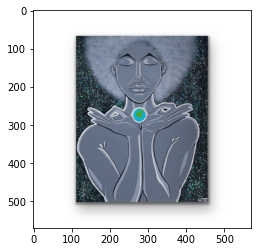

In [196]:
imgplot = plt.imshow(img)

In [304]:
img.shape

(570, 570, 3)

#### Let's check the color properties of the image

In [227]:
#Let's check if the mean colors actually match those reported by the /images request 
import numpy as np

r_mean, g_mean, b_mean = np.mean(img,axis=(0,1))


In [228]:
r_mean

175.06739919975377

In [229]:
g_mean

180.66092336103415

In [261]:
b_mean

187.952004

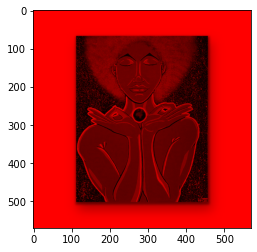

In [202]:
img_red = img.copy()
img_red[:,:,1:]=0
plt.imshow(img_red)

# #Alternatively:
# img_red = np.zeros(img.shape,dtype=int)
# img_red[:,:,0]=img[:,:,0]
# plt.imshow(img_red)

In [235]:
np.mean(img_red,axis=(0,1))

array([175.0673992,   0.       ,   0.       ])

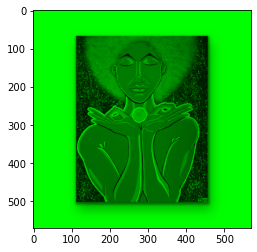

In [211]:
img_green = img.copy()
img_green[:,:,0]=0
img_green[:,:,2]=0
plt.imshow(img_green)

# # #Alternatively:
# img_green = np.zeros(img.shape,dtype=int)
# img_green[:,:,1]=img[:,:,1]
# plt.imshow(img_green)

In [236]:
np.mean(img_green,axis=(0,1))

array([  0.        , 180.66092336,   0.        ])

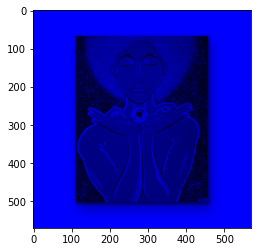

In [218]:
img_blue = img.copy()
img_blue[:,:,:2]=0
plt.imshow(img_blue)

# # #Alternatively:
# img_blue = np.zeros(img.shape,dtype=int)
# img_blue[:,:,2]=img[:,:,2]
# plt.imshow(img_blue)

In [237]:
np.mean(img_blue,axis=(0,1))

array([  0.        ,   0.        , 187.91155125])

In [216]:
img_test = img_red + img_green + img_blue

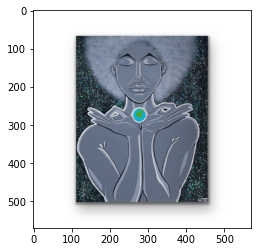

In [217]:
plt.imshow(img_test)

In [221]:
#Note that the average colors don't match those reported... maybe because I am using the image resized to weird dimensions?

In [222]:
#Let's try to load the full size image and see if that works:
sample_image_full = download_image(url_listing_sample_image_full_img,images_folder)

In [240]:
sample_image_full

'./Git_exclude/Painting_images/il_fullxfull.3120353037_hxif.jpg'

In [241]:
img_full = mpimg.imread(sample_image_full)

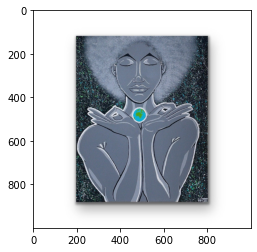

In [242]:
imgplot_full = plt.imshow(img_full)

In [244]:
img_full.shape

(1000, 1000, 3)

In [245]:
r_mean, g_mean, b_mean = np.mean(img_full,axis=(0,1))

In [262]:
r_mean

175.070757

In [264]:
r_mean_nocontour, g_mean_nocontour, b_mean_nocontour = np.mean(img_full[200:800,150:850,:],axis=(0,1))

In [266]:
r_mean_nocontour

110.41776666666667

In [268]:
g_mean_nocontour

121.07627380952381

In [269]:
b_mean_nocontour

134.62788333333333

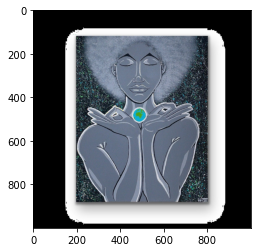

In [271]:
#Maybe the average is computed after removing all white pixels that surround the true image?

img_no_contour = np.zeros(img_full.shape,dtype=int)

img_no_contour[np.where(img_full!=[255,255,255])] = img_full[np.where(img_full!=[255,255,255])]

plt.imshow(img_no_contour)


In [273]:
r_mean_no_contour, g_mean_no_contour, b_mean_no_contour = np.mean(img_no_contour,axis=(0,1))
r_mean_no_contour

85.832232

In [275]:
g_mean_no_contour

91.4604

In [282]:
b_mean_no_contour

98.648964

In [ ]:
r_mean, g_mean, b_mean 

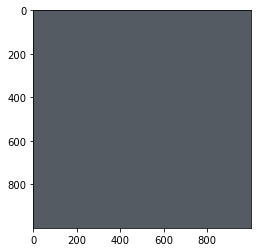

In [290]:
img_mean = np.zeros(img_full.shape,dtype=int)

img_mean[:,:,0] = r_mean_no_contour #r_mean
img_mean[:,:,1] = g_mean_no_contour #g_mean
img_mean[:,:,2] = b_mean_no_contour #b_mean

plt.imshow(img_mean)

### Try a different image of the same listing, with background

In [291]:
url_listing_sample_image_570N_alt = 'https://openapi.etsy.com/v3/application/shops/{shop_id}/listings/{listing_id}/images/{listing_image_id}'.format(shop_id=first_100acrylic_paintings_df.iloc[0]['shop_id'],
                                                        listing_id=first_100acrylic_paintings_df.iloc[0]['listing_id'], listing_image_id=sample_listing_all_images_df['listing_image_id'].iloc[1])
url_listing_sample_image_570N_alt

'https://openapi.etsy.com/v3/application/shops/26357829/listings/1016665059/images/3072618496'

In [292]:
response_listing_sample_image_alt = requests.get(url_listing_sample_image_570N_alt, headers = headers)
response_listing_sample_image_alt


<Response [200]>

In [293]:
response_listing_sample_image_alt_data = response_listing_sample_image_alt.json() 
response_listing_sample_image_alt_data.keys()

dict_keys(['listing_id', 'listing_image_id', 'hex_code', 'red', 'green', 'blue', 'hue', 'saturation', 'brightness', 'is_black_and_white', 'creation_tsz', 'rank', 'url_75x75', 'url_170x135', 'url_570xN', 'url_fullxfull', 'full_height', 'full_width'])

In [294]:
#The above doesn't return the image itself.. only metadata
url_listing_sample_image_570N_img_alt = sample_listing_all_images_df['url_570xN'].iloc[1]
url_listing_sample_image_570N_img_alt

'https://i.etsystatic.com/26357829/r/il/540db4/3072618496/il_570xN.3072618496_4zg7.jpg'

In [296]:
images_folder = './Git_exclude/Painting_images/'
sample_image_570N_alt = download_image(url_listing_sample_image_570N_img_alt,images_folder)

img_alt = mpimg.imread(sample_image_570N_alt)

In [297]:
img_alt = mpimg.imread(sample_image_570N_alt)

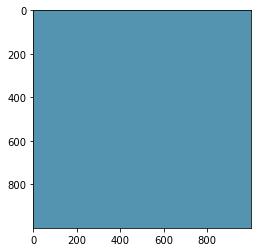

In [298]:
img_alt_mean = np.zeros(img_full.shape,dtype=int)

r_mean_alt, g_mean_alt, b_mean_alt = np.mean(img_alt,axis=(0,1))

img_alt_mean[:,:,0] = r_mean_alt #r_mean
img_alt_mean[:,:,1] = g_mean_alt #g_mean
img_alt_mean[:,:,2] = b_mean_alt #b_mean

plt.imshow(img_alt_mean)

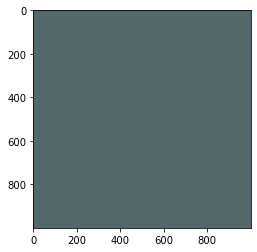

In [300]:
#So the manual average of the image does in fact pick up the background mostly
#Is it the same for the numbers returned by the GET request?

img_alt_mean_listing = np.zeros(img_full.shape,dtype=int)

r_mean_alt_listing = sample_listing_all_images_df['red'].iloc[1]
g_mean_alt_listing = sample_listing_all_images_df['green'].iloc[1]
b_mean_alt_listing = sample_listing_all_images_df['blue'].iloc[1]

img_alt_mean_listing[:,:,0] = r_mean_alt_listing #r_mean
img_alt_mean_listing[:,:,1] = g_mean_alt_listing #g_mean
img_alt_mean_listing[:,:,2] = b_mean_alt_listing #b_mean

plt.imshow(img_alt_mean_listing)

#So the mean colors returned by the listing seems to be robust to the profile, and I can consider it reliable for the most part.


### Get variation images

In [295]:
#Get all variation images for this listing, maybe there's another image with the right size without background?

url_listing_variation_images = 'https://openapi.etsy.com/v3/application/shops/{shop_id}/listings/{listing_id}/variation-images'.format(shop_id=first_100acrylic_paintings_df.iloc[0]['shop_id'],
                                                        listing_id=first_100acrylic_paintings_df.iloc[0]['listing_id'])
url_listing_variation_images

'https://openapi.etsy.com/v3/application/shops/26357829/listings/1016665059/variation-images'

In [248]:
response_listing_variation_images = requests.get(url_listing_variation_images, headers = headers)

In [250]:
response_listing_variation_images = response_listing_variation_imagese

In [251]:
response_listing_variation_images_data = response_listing_variation_images.json() 

In [252]:
response_listing_variation_images_data.keys()

dict_keys(['count', 'results'])

In [285]:
response_listing_variation_images_data['count']

0

### Sample image processing with PIL 

In [281]:
from PIL import ImageFilter, Image, ImageStat

with Image.open(sample_image_full) as im:
    #im.show()
    #im_new = im.filter(ImageFilter.FIND_EDGES)
    #im_new.show()
    print(ImageStat.Stat(im).var)
    


[7150.8723044469525, 6262.51064384, 5368.759188383988]


In [289]:
print(ImageStat.Stat(im).mean)

[175.070757, 180.7104, 187.952004]
